# Get petioles

The petiole is the part that connects the leaf to the main stem. This notebook attempts to segment out leaves while keeping the petiole intact.

Based on previous discussions, I assume that the pots will be transparent or below the level of the plant, and the leaves will not go outside of the pot. Therefore I do not attempt to address these problems in this notebook.

In [1]:
import os
import math
import importlib
import pandas as pd

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import scipy.ndimage as ndimage

import tifffile as tf

import arabidopsis_utils as thales

from PIL import Image, ImageDraw

In [2]:
dst = 'petiole/'
tiff_file  = 'col-0.tif'

In [3]:
_ , fname = os.path.split(tiff_file)
bname = os.path.splitext(fname)[0]
img = tf.imread(tiff_file)

## Separate pots

Since we are not thresholding out air or soil, we create a 2-d image by taking the maximum value of each 0th coordinate column. After the first cell, the strategy follows Erik's code

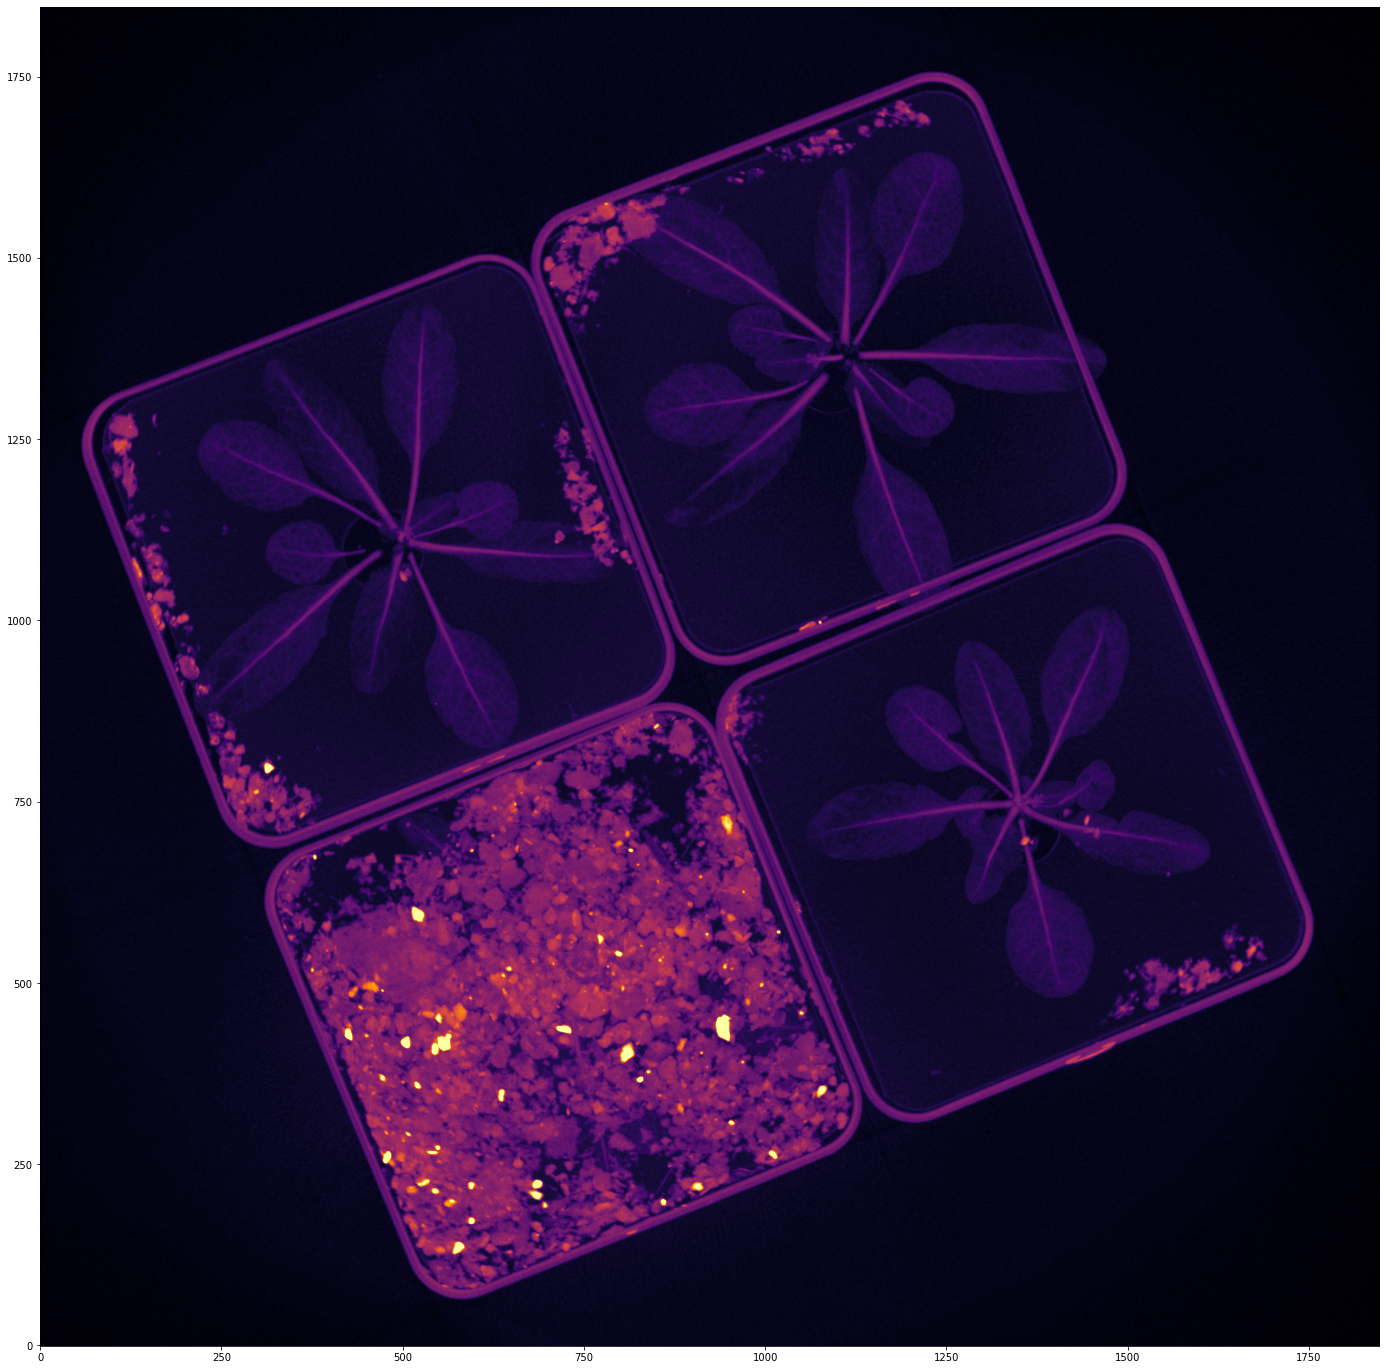

In [4]:
max_image = np.zeros(shape=(img.shape[1], img.shape[2]))

for i in range(img.shape[1]):
    for j in range(img.shape[2]):
        max_image[i,j] = np.max(img[190:1000,i,j]) # only select slices that contain plant material

fig, ax = plt.subplots(figsize = (24,36))
im = ax.imshow(max_image, cmap='inferno', origin='lower', vmax =75)

plt.show()

In [5]:
pts = max_image.astype(np.uint8)

In [6]:
# be aggressive here, choice is only to get pot outline for bounding box.
pts[pts < 30] = 0 # 30 for col-0 37 for u112-3
pts[pts > 0] = 1
border = np.array([[-1, -1, -1],
                   [-1, 8, -1],
                   [-1, -1, -1]])

surface = ndimage.convolve(pts, border, np.int8, 'constant', cval=0)
surface[ surface < 0 ] = 0
surface = surface.astype(np.uint8)
surface[ surface > 0 ] = 1

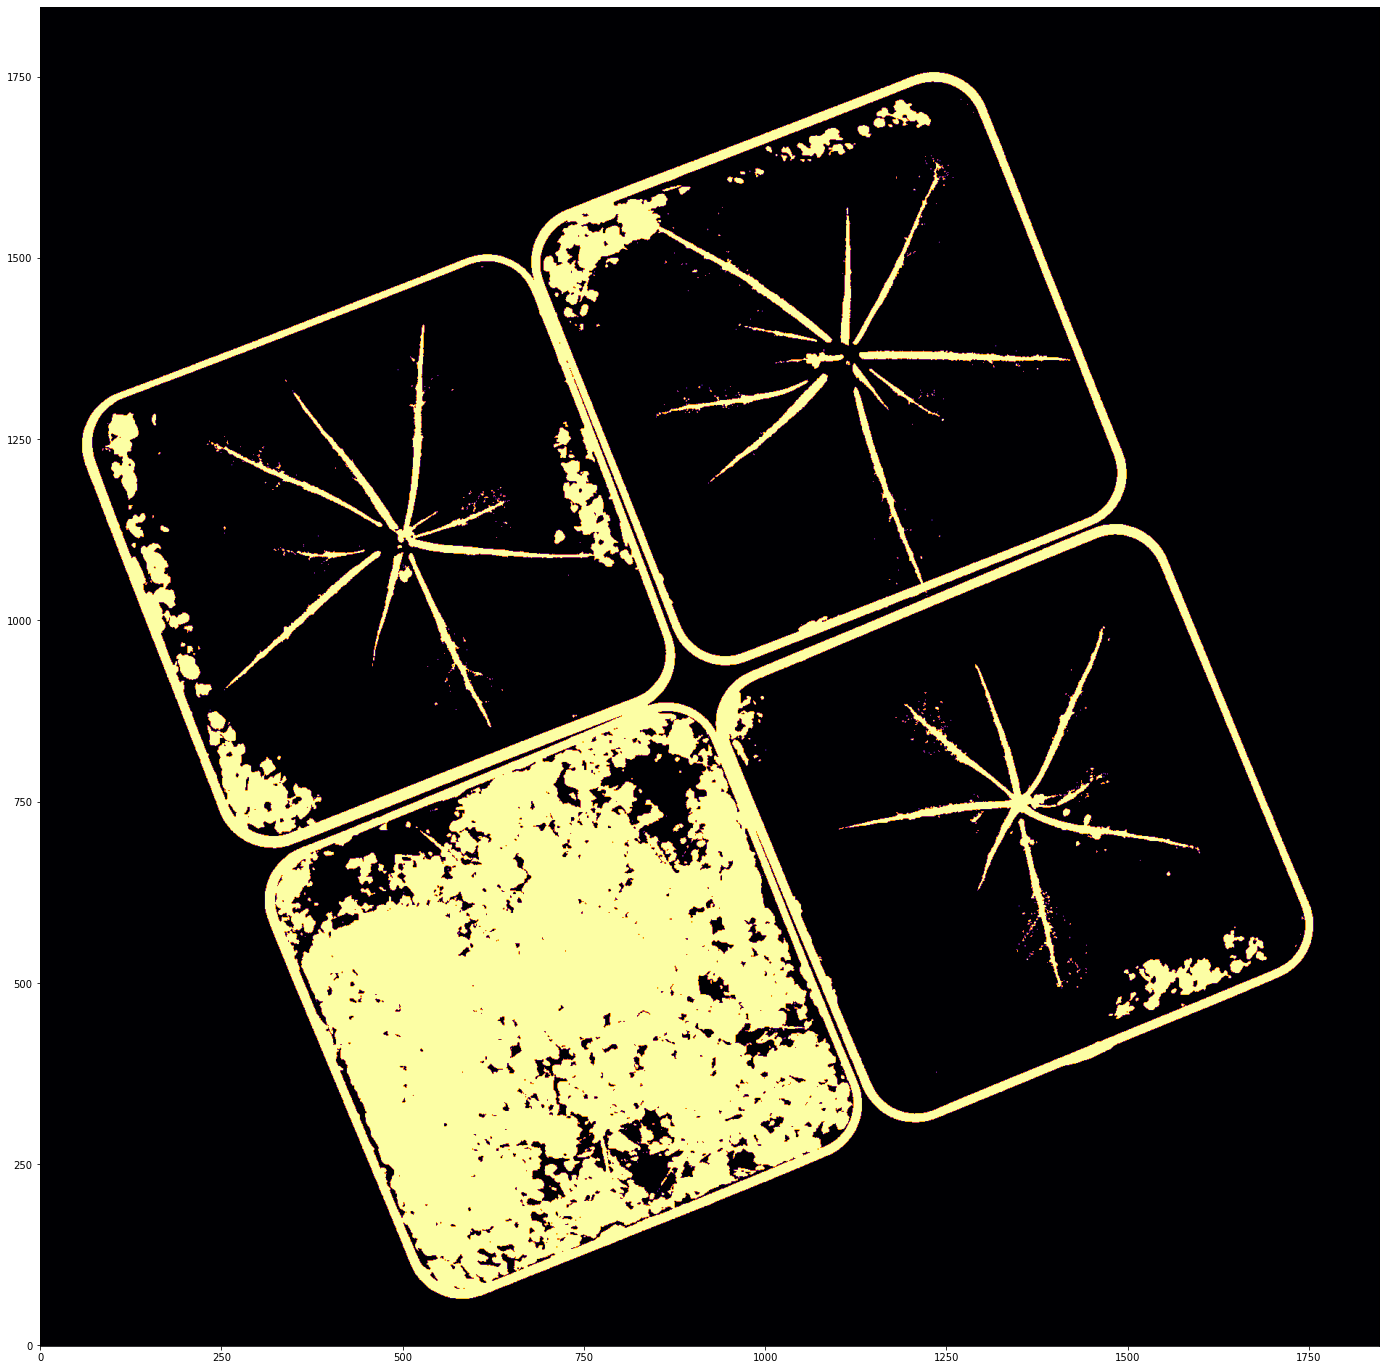

In [7]:
fig, ax = plt.subplots(figsize = (24,36))
im = ax.imshow(pts, cmap='inferno', origin='lower')

plt.show()

In [8]:
# get bounding box of all 4 plants
corners = thales.four_corners(pts)
tpt, rpt, bpt, lpt = corners
center = np.mean(corners,axis=0)
print(tpt, rpt, bpt, lpt, sep='\n')

rhull = np.vstack((lpt,tpt,rpt,bpt,lpt))

[1787.21724016 1270.80363209]
[ 531.14578408 1780.83081361]
[ 25.5475482  535.66676091]
[1281.61900428   25.63957938]


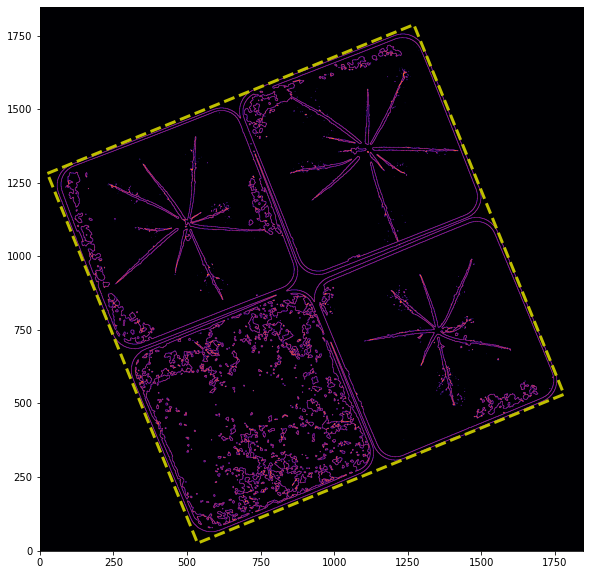

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(surface, cmap='inferno', origin='lower');
#plt.plot(rect[hull.vertices,1], rect[hull.vertices,0], 'y--', lw=2);
plt.plot(rhull[:,1], rhull[:,0], 'y--', lw=3);

In [10]:
# get coordinates midpoints, centers (shown below)
bcoefs = thales.four_borderlines(corners)
midpoints = thales.four_midpoints(corners)
mcoefs = thales.midline_splits(midpoints)
centers = thales.four_centers(corners, midpoints)

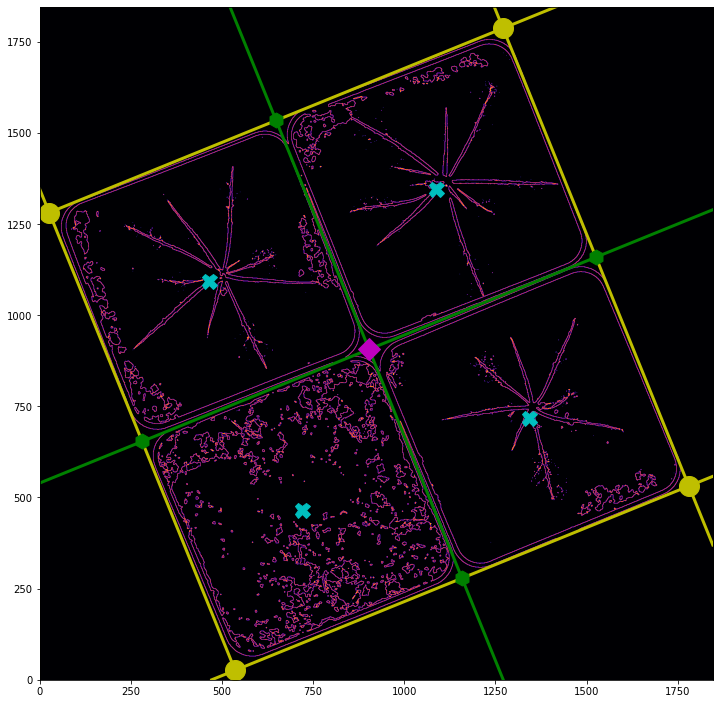

In [11]:
plt.figure(figsize=(10,10))
plt.imshow(surface, cmap='inferno', origin='lower');
for i in range(len(bcoefs)):
    plt.axline(corners[i,:][::-1], slope=bcoefs[i,1], c='y', lw=3)
    plt.plot(corners[i,1], corners[i,0], 'yo', ms=20)
    plt.plot(centers[i,1], centers[i,0], 'cX', ms=15)
    plt.plot(midpoints[i,1], midpoints[i,0], 'gh', ms=15)
for i in range(len(mcoefs)):
    plt.axline(midpoints[i,:][::-1], slope=mcoefs[i,1], c='g', lw=3)

plt.plot(center[1], center[0], 'mD', ms=15);
plt.tight_layout()

filename = dst + bname + '_split_pots.jpg'
plt.savefig(filename, dpi=96, pil_kwargs={'optimize':True})

For each pot, create a mask that will show only that pot. Each pot is drawn clockwise, starting from top.

In [12]:
# need to flip these around to draw the polygon
midpoints_reverse = midpoints.astype(int)
midpoints_reverse = midpoints_reverse[:,[1,0]]

In [13]:
center_reverse = center.astype(int)
center_reverse = center_reverse[[1,0]]

In [14]:
corners_reverse = corners.astype(int)
corners_reverse = corners_reverse[:,[1,0]]

In [15]:
width = img.shape[1]
height = img.shape[2]

In [16]:
# draw each pot, based on the four corners, going clockwise
polygon0 = [tuple(corners_reverse[0]),tuple(midpoints_reverse[0]),tuple(center_reverse),tuple(midpoints_reverse[3])]

img0 = Image.new('L', (width, height), 0)
ImageDraw.Draw(img0).polygon(polygon0, outline=1, fill=1)
mask0 = np.array(img0)

In [17]:
polygon1 = [tuple(midpoints_reverse[0]),tuple(corners_reverse[1]),tuple(midpoints_reverse[1]),tuple(center_reverse)]

img1 = Image.new('L', (width, height), 0)
ImageDraw.Draw(img1).polygon(polygon1, outline=1, fill=1)
mask1 = np.array(img1)

In [18]:
polygon2 = [tuple(center_reverse),tuple(midpoints_reverse[1]),tuple(corners_reverse[2]),tuple(midpoints_reverse[2])]

img2 = Image.new('L', (width, height), 0)
ImageDraw.Draw(img2).polygon(polygon2, outline=1, fill=1)
mask2 = np.array(img2)

In [19]:
polygon3 = [tuple(midpoints_reverse[3]),tuple(center_reverse),tuple(midpoints_reverse[2]),tuple(corners_reverse[3])]

img3 = Image.new('L', (width, height), 0)
ImageDraw.Draw(img3).polygon(polygon3, outline=1, fill=1)
mask3 = np.array(img3)

An area of improvement would be to figure out a less repetetive way to code this (using a dictionary and/or for loop)

In [20]:
# isolate each pot, by multiplying all non-pot pixels by zero
pot0 = np.multiply(mask0,max_image)
pot1 = np.multiply(mask1,max_image)
pot2 = np.multiply(mask2,max_image)
pot3 = np.multiply(mask3,max_image)

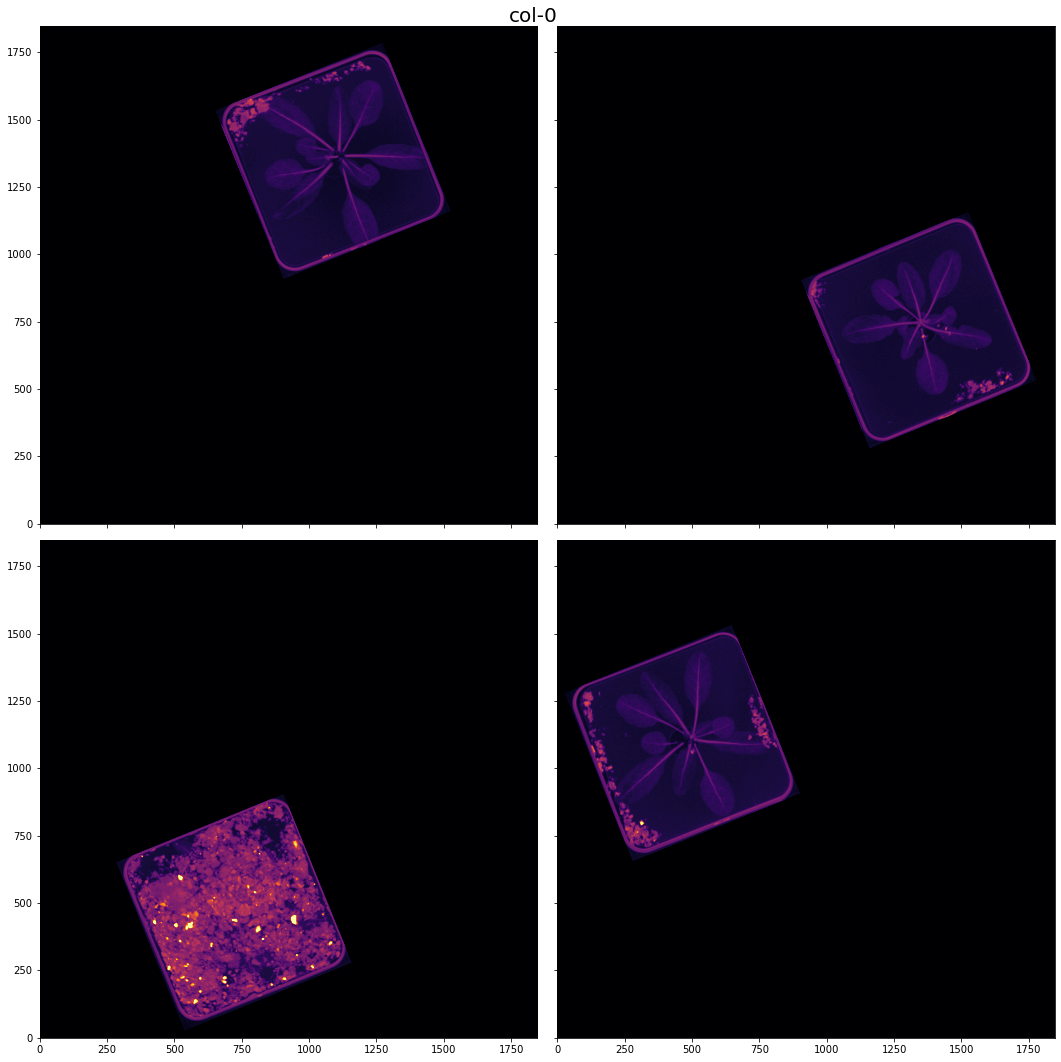

In [21]:
fig, ax = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey= True)

ax[0,0].imshow(pot0, cmap='inferno', origin='lower', vmin = 19, vmax = 75);
ax[0,1].imshow(pot1, cmap='inferno', origin='lower', vmin = 19, vmax = 75);
ax[1,0].imshow(pot2, cmap='inferno', origin='lower', vmin = 19, vmax = 75);
ax[1,1].imshow(pot3, cmap='inferno', origin='lower', vmin = 19, vmax = 75);

fig.suptitle(bname, fontsize = 20)

fig.tight_layout()
filename = dst + bname +'petiole_separated_pots_4_binary.jpg'
plt.savefig(filename, dpi=96, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')

# Get conical volume of "allowed" voxels

Now we create a second mask for each pot. The idea here is that an arabidopsis plant is roughly conical (albeit a very flat cone), so if all voxels outside the cone are zero, that will take away most of the air and soil.

In [22]:
# crop each pot, and get new centers

In [23]:
# only need slices that actually have the plant
plant_only = img[190:1000]

In [24]:
# get stack of slices, but only show one pot
pot0_stack = plant_only*mask0
pot1_stack = plant_only*mask1
pot2_stack = plant_only*mask2
pot3_stack = plant_only*mask3

In [25]:
# cut out most of the black area, make image quicker to work with
pot0_stack = thales.clean_zeroes(pot0_stack)[0]
pot1_stack = thales.clean_zeroes(pot1_stack)[0]
pot2_stack = thales.clean_zeroes(pot2_stack)[0]
pot3_stack = thales.clean_zeroes(pot3_stack)[0]

77 % reduction from input
77 % reduction from input
77 % reduction from input
77 % reduction from input


In [26]:
# to get new center of each pot, pick a random nonzero slice and use function from before
# the center of each plant is close enough to the center of the pot, so we will just center the cone there
def get_new_center(stack):
    pot_stack = stack[500]
    corners2 = thales.four_corners(pot2_stack[500]) # the 2 is just an artifact from function writing
    tpt, rpt, bpt, lpt = corners2
    center2 = np.mean(corners2,axis=0)
    center2_reverse = center2.astype(int)
    center2_reverse = center2_reverse[[1,0]]
    return center2_reverse

In [27]:
center0 = get_new_center(pot0_stack)
center1 = get_new_center(pot1_stack)
center2 = get_new_center(pot2_stack)
center3 = get_new_center(pot3_stack)

In [28]:
# https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [29]:
def get_conical_stack(pot_stack, center, radius_coeff):
    # make a copy so the input does not get changed (in case we want to change coefficient)
    pot_stack_copy = pot_stack.copy()
    
    # Multiply each layer of the pot stack by the conical mask
    for i in range(0, len(pot_stack)):
        circular_mask = create_circular_mask(pot_stack[500].shape[0],pot_stack[500].shape[1], center = center2, radius = radius_coeff*i)
        pot_stack_copy[i] = pot_stack[i]*circular_mask
        
    return pot_stack_copy   

In [30]:
# Like before, we take the maximum of each 0th axis column
def get_max_pot(pot_stack):

    # just choose a random slice to get shape
    max_pot = np.zeros(pot_stack[500].shape)

    for i in range(pot_stack[500].shape[0]):
        for j in range(pot_stack[500].shape[1]):
            max_pot[i,j] = np.max(pot_stack[:,i,j])
    
    return max_pot

In [31]:
max_pot0 = get_max_pot(get_conical_stack(pot0_stack, center0, 6))
max_pot1 = get_max_pot(get_conical_stack(pot1_stack, center1, 6))
max_pot2 = get_max_pot(get_conical_stack(pot2_stack, center2, 2))
max_pot3 = get_max_pot(get_conical_stack(pot3_stack, center3, 6))

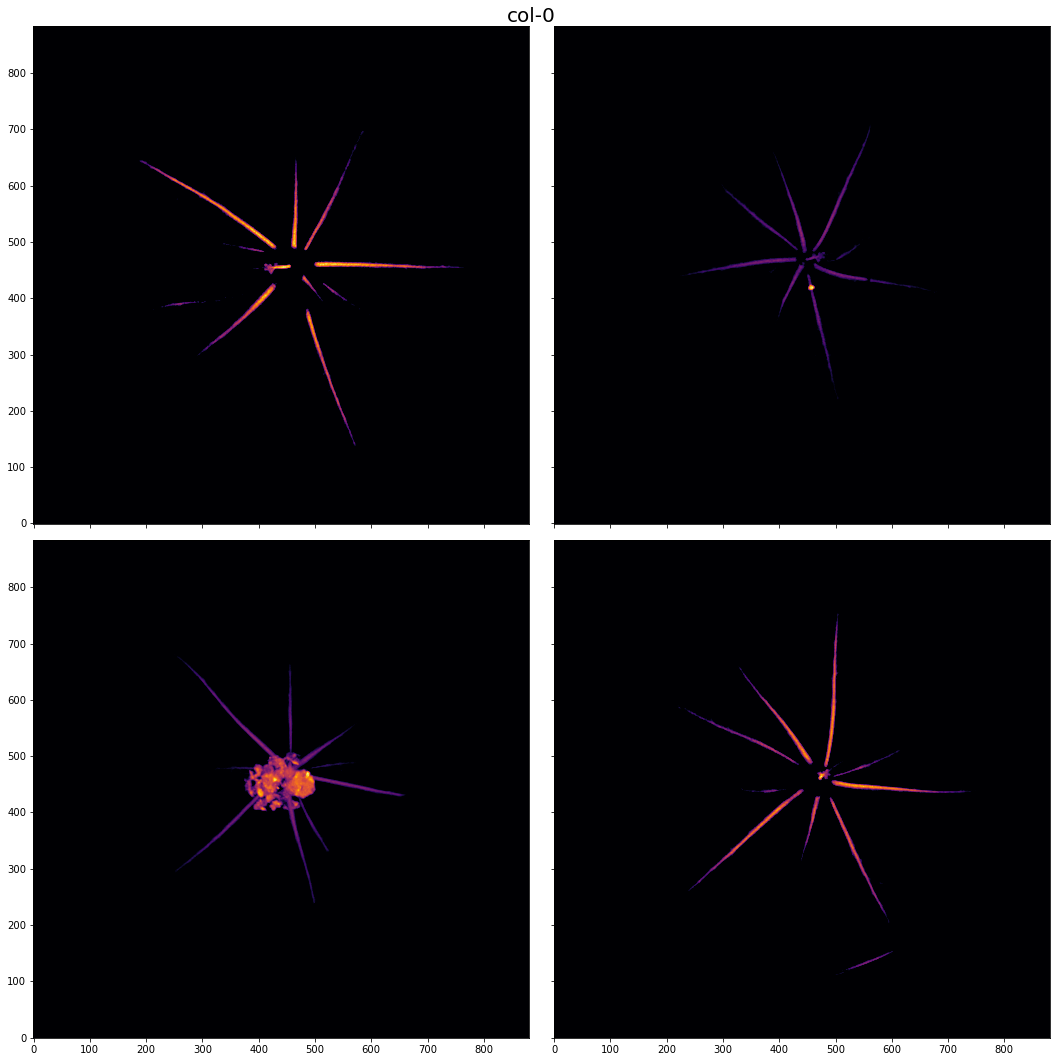

In [43]:
fig, ax = plt.subplots(2,2, figsize=(15,15), sharex=True, sharey= True)

ax[0,0].imshow(max_pot0, cmap='inferno', origin='lower', vmin = 30);
ax[0,1].imshow(max_pot1, cmap='inferno', origin='lower', vmin = 30);
ax[1,0].imshow(max_pot2, cmap='inferno', origin='lower', vmin = 30);
ax[1,1].imshow(max_pot3, cmap='inferno', origin='lower', vmin = 30);

fig.suptitle(bname, fontsize = 20)

fig.tight_layout()
filename = dst + bname +'petiole_separated_pots_4.jpg'
plt.savefig(filename, dpi=96, format='jpg', pil_kwargs={'optimize':True}, bbox_inches='tight')

# Moving to 3d

Taking the maximum along the 0th axis creates a 2-d image. We want to obtain an image similar to above, but in three dimensions, for watershedding purposes

In [33]:
# keep only the max voxel in each z-axis column, make everything else 0

def max_stack(pot_stack, max_pot, threshold):
    pot_stack_copy = get_conical_stack(pot_stack, center0, 6)
    
    # the max value is repeated many times in the dirt, so threshold out
    pot_stack_copy[pot_stack_copy<threshold] = 0
    
    for i in range(0, pot_stack_copy.shape[1]):
        for j in range(0, pot_stack_copy.shape[2]):
            pot_stack_copy[:,i,j][pot_stack_copy[:,i,j]<max_pot[i,j]] = 0
            pot_stack_copy[:,i,j][pot_stack_copy[:,i,j]>0] = 1
    return pot_stack_copy

In [34]:
max_stack0 = max_stack(pot0_stack, max_pot0, 25)

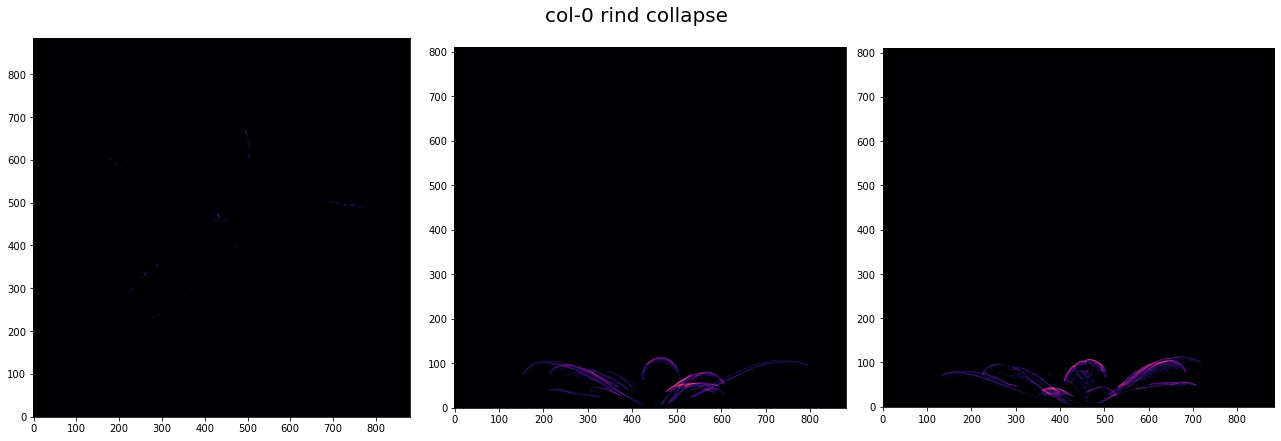

In [35]:
snaps = thales.collapse_dimensions(max_stack0)
thales.plot_collapse_dimensions(snaps, bname, 'rind', vmin = 3)